<h1>Description of the problem</h1> 

>A bit of **background**: in the digital marketing world it is really important to retain the customers (not to let them *churn* / unsubscribe). Most big companies have churn prediction models which are based on customer data. Attached is a dataset for a mobile company in which different features of each customer are shown (in different columns), and in the last column you can see if they churned or not.

We have a dataset from a mobile company including a few hundred customers. For each customer, we have some features (gender, tenure, etc.) and we know if they have churned or not. The goal of this project is to see if by looking at the value of these features, we can learn a model that will predict whether a customer will leave (churn) or stay. This is an example of **supervised machine learning** project. All supervised algorithms have some features and related target/label values. This problem is also a binary classification because our target is either someone who has churned or not.   

The focus of the project is to build a churn predictive model. 
Here, are the major steps that we will take: 
1. Data exploration and visualization
2. Data cleaning / pre-processing
3. Choice of predictive model and features
4. Use CV to train and evaluate our model
5. Description of outcomes / conclusion

## 0. Preliminaries

First, we import the libraries necessary for dealing with numbers, dataframes, and plotting. 

In [1]:
# import relevant libraries
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## 1. Data exploration

Next, we import the dataset and explore its shape. How does it look?

In [2]:
# load dataset
ds = pd.read_csv('churn.csv')
display(ds.head())
print(ds.shape)
print(ds.columns)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


(7043, 21)
Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')


In [3]:
# display summary stats for numeric features
ds.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


Churn
No     [[AxesSubplot(0.125,0.551739;0.336957x0.328261...
Yes    [[AxesSubplot(0.125,0.551739;0.336957x0.328261...
dtype: object

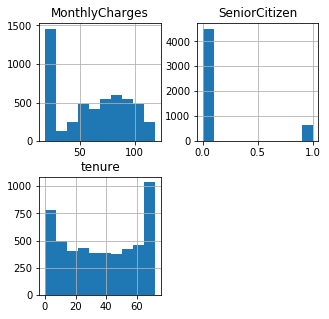

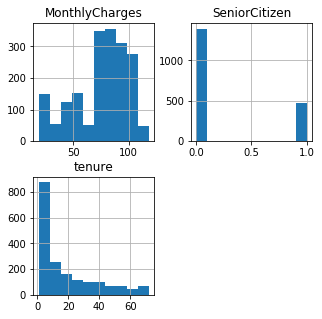

In [4]:
# Plot exploratory histograms for numeric variables, separately for stay or left
ds.groupby('Churn').hist(figsize=(5, 5))

>ds.describe() and groupby only return summary statistics and histograms for three columns. This is because it only works with numberical variables. To have a better overview of the data, we'll have to convert strings into numbers/codes. But before doing that, let's inspect if we have any missing values:

In [5]:
# look for nan and null
print(ds.isnull().values.any())

False


In [6]:
# Check how many people ended up churning
left = ds[ds.Churn=='Yes']
stay = ds[ds.Churn=='No']
print("Number of people who left:", left['Churn'].count())
print("Number of people who stayed:", stay['Churn'].count())

Number of people who left: 1869
Number of people who stayed: 5174


>Looks like most people in the dataset actually stayed with the company (i.e. did not churn).

## 2. Pre-processing

Now let's turn strings into numbers so that we can deal with all of the features in the dataset.

In [7]:
# Let's turn string entries into numeric ones
ds['genderID'] = np.double(ds.gender=='Female')
ds['partnerID'] = np.double(ds.Partner=='Yes')
ds['dependentsID'] = np.double(ds.Dependents=='Yes')
ds['phoneservID'] = np.double(ds.PhoneService=='Yes')

ds.loc[ds[ds.MultipleLines=='No phone service'].index, 'multlinesID'] = -1
ds.loc[ds[ds.MultipleLines=='No'].index, 'multlinesID'] = 0
ds.loc[ds[ds.MultipleLines=='Yes'].index, 'multlinesID'] = 1

ds.loc[ds[ds.InternetService=='No'].index, 'internetID'] = -1
ds.loc[ds[ds.InternetService=='DSL'].index, 'internetID'] = 1
ds.loc[ds[ds.InternetService=='Fiber optic'].index, 'internetID'] = 2

ds.loc[ds[ds.OnlineSecurity=='No internet service'].index, 'securityID'] = -1
ds.loc[ds[ds.OnlineSecurity=='No'].index, 'securityID'] = 0
ds.loc[ds[ds.OnlineSecurity=='Yes'].index, 'securityID'] = 1

ds.loc[ds[ds.OnlineBackup=='No internet service'].index, 'backupID'] = -1
ds.loc[ds[ds.OnlineBackup=='No'].index, 'backupID'] = 0
ds.loc[ds[ds.OnlineBackup=='Yes'].index, 'backupID'] = 1

ds.loc[ds[ds.DeviceProtection=='No internet service'].index, 'devprotID'] = -1
ds.loc[ds[ds.DeviceProtection=='No'].index, 'devprotID'] = 0
ds.loc[ds[ds.DeviceProtection=='Yes'].index, 'devprotID'] = 1

ds.loc[ds[ds.TechSupport=='No internet service'].index, 'techsuppID'] = -1
ds.loc[ds[ds.TechSupport=='No'].index, 'techsuppID'] = 0
ds.loc[ds[ds.TechSupport=='Yes'].index, 'techsuppID'] = 1

ds.loc[ds[ds.StreamingTV=='No internet service'].index, 'streamtvID'] = -1
ds.loc[ds[ds.StreamingTV=='No'].index, 'streamtvID'] = 0
ds.loc[ds[ds.StreamingTV=='Yes'].index, 'streamtvID'] = 1

ds.loc[ds[ds.StreamingMovies=='No internet service'].index, 'streammovID'] = -1
ds.loc[ds[ds.StreamingMovies=='No'].index, 'streammovID'] = 0
ds.loc[ds[ds.StreamingMovies=='Yes'].index, 'streammovID'] = 1

ds.loc[ds[ds.Contract=='Month-to-month'].index, 'contractID'] = 0
ds.loc[ds[ds.Contract=='One year'].index, 'contractID'] = 1
ds.loc[ds[ds.Contract=='Two year'].index, 'contractID'] = 2

ds['paperlessID'] = np.double(ds.PaperlessBilling=='Yes')

ds.loc[ds[ds.PaymentMethod=='Bank transfer (automatic)'].index, 'paymentID'] = 1
ds.loc[ds[ds.PaymentMethod=='Credit card (automatic)'].index, 'paymentID'] = 2
ds.loc[ds[ds.PaymentMethod=='Electronic check'].index, 'paymentID'] = 3
ds.loc[ds[ds.PaymentMethod=='Mailed check'].index, 'paymentID'] = 4

ds['churnID'] = np.double(ds.Churn=='Yes')

# Let's drop some features that are not useful
ds = ds.drop(columns=['customerID'])

# Let's save the new clean dataset
ds.to_csv('churn_clean.csv', index=False)

In [8]:
# Now import clean dataset
df = pd.read_csv('churn_clean.csv')
print(df.shape)
display(df.iloc[:,20:].head())

(7043, 36)


,genderID,partnerID,dependentsID,phoneservID,multlinesID,internetID,securityID,backupID,devprotID,techsuppID,streamtvID,streammovID,contractID,paperlessID,paymentID,churnID
0,1.0,1.0,0.0,0.0,-1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0
1,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,4.0,0.0
2,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,1.0
3,0.0,0.0,0.0,0.0,-1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
4,1.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0


>The new dataset has nearly twice as many features. This is because we only added, not replaced, the old features with the new number-coded ones. But at least now we can use describe() to take a look.

In [9]:
# display summary stats for numeric features
display(df.iloc[:,:].describe())

,SeniorCitizen,tenure,MonthlyCharges,genderID,partnerID,dependentsID,phoneservID,multlinesID,internetID,securityID,backupID,devprotID,techsuppID,streamtvID,streammovID,contractID,paperlessID,paymentID,churnID
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,0.495244,0.483033,0.299588,0.903166,0.325004,1.006247,0.069999,0.128212,0.127219,0.073548,0.167684,0.171234,0.690473,0.592219,2.574329,0.265370
std,0.368612,24.559481,30.090047,0.500013,0.499748,0.458110,0.295752,0.642730,1.142982,0.706051,0.738369,0.737868,0.708201,0.756958,0.758507,0.833755,0.491457,1.068104,0.441561
min,0.000000,0.000000,18.250000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,0.000000,1.000000,0.000000
25%,0.000000,9.000000,35.500000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000
50%,0.000000,29.000000,70.350000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000,0.000000
75%,0.000000,55.000000,89.850000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,1.000000
max,1.000000,72.000000,118.750000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,4.000000,1.000000


churnID
0.0    [[AxesSubplot(0.125,0.758226;0.158163x0.121774...
1.0    [[AxesSubplot(0.125,0.758226;0.158163x0.121774...
dtype: object

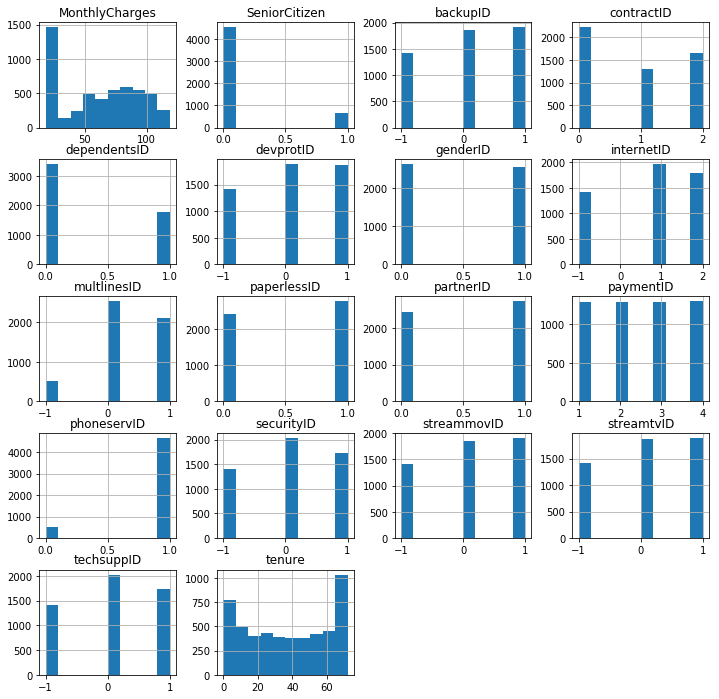

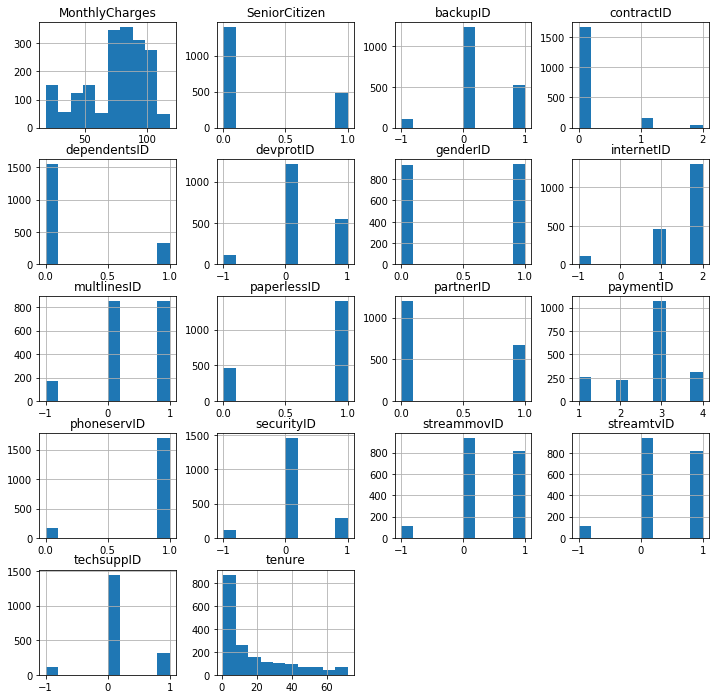

In [10]:
# Re-explore features
df.groupby('churnID').hist(figsize=(12, 12))

## 3. Feature selection

From an initial quick look at the histograms, we have some good preliminary candidate features that appear to differ between people who ended up churning and those who stayed: tenure, monthly charges, contract ID.

In [11]:
# Let's select explanatory features (X) and the response variables (Y)
X = df[['tenure', 'MonthlyCharges', 'contractID']] # features we use for prediction
Y = df.churnID # what we are predicting

# Let's take a quick look at the shape of our variables
print(X.shape)
print(Y.shape)

(7043, 3)
(7043,)


In [12]:
# Let's standardize our data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_standard = scaler.fit_transform(X)

In [13]:
# And split dataset into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_evaluate, Y_train, Y_evaluate = train_test_split(X_standard, Y, test_size=0.3)
print(X_train.shape)
print(X_evaluate.shape)

(4930, 3)
(2113, 3)


In [14]:
# Finally, let's run our logistic regression model and create our predictions
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(X_train, Y_train)
Y_pred = clf.predict(X_evaluate)
print(Y_pred.shape)

(2113,)


## 4. Model evaluation

The final step is to evaluate our model. How many times our predictions about churning turned out to be correct?

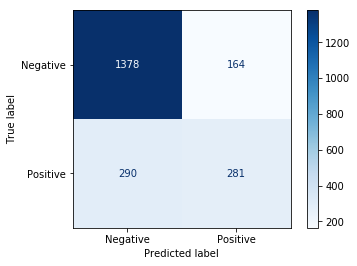

In [15]:
# Let's create a confusion matrix to get all possible outcomes
from sklearn.metrics import plot_confusion_matrix
class_names = ['Negative', 'Positive']
plot_confusion_matrix(clf, X_evaluate, Y_evaluate, cmap=plt.cm.Blues, display_labels=class_names)

In [16]:
# Let's now get the values from the confusion matrix
from sklearn.metrics import confusion_matrix
con_mat = confusion_matrix(Y_evaluate, Y_pred)

In [17]:
# coding true positives, true negatives, etc
TP = con_mat[1,1] # true positives
TN = con_mat[0,0] # true negatives
FP = con_mat[0,1] # false positives
FN = con_mat[1,0] # false negatives

In [18]:
# calculating recall, precision, and accuracy
recall = TP/(TP + FN)
print(f'Recall is {recall:.2f}')

precision = TP/(TP + FP)
print(f'Precision is {precision:.2f}')

accuracy = (TP + TN)/(TP + TN + FP + FN)
print(f'Accuracy is {accuracy:.2f}')

Recall is 0.49
Precision is 0.63
Accuracy is 0.79


Our model has a prediction accuracy of nearly 80%. Not bad, but perhaps we can improve it by selecting all the features instead of our small subset. Because we train and test on independent portions of the dataset, this won't be a problem. Let's repeat the main steps:

In [19]:
X = df.iloc[:,20:-1] # features we use for prediction
Y = df.churnID # what we are predicting

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_standard = scaler.fit_transform(X)

from sklearn.model_selection import train_test_split
X_train, X_evaluate, Y_train, Y_evaluate = train_test_split(X_standard, Y, test_size=0.3)

from sklearn.metrics import confusion_matrix
con_mat = confusion_matrix(Y_evaluate, Y_pred)

recall = TP/(TP + FN)
print(f'Recall is {recall:.2f}')
precision = TP/(TP + FP)
print(f'Precision is {precision:.2f}')
accuracy = (TP + TN)/(TP + TN + FP + FN)
print(f'Accuracy is {accuracy:.2f}')

Recall is 0.49
Precision is 0.63
Accuracy is 0.79


## 5. Conclusions

Even after including all of the available features, our prediction accuracy remained roughly the same. This means that our original parsimonious model was already doing a good job at capturing most of the variance in the data. In other words, the most important features for predicting whether customers will churn or not are: 

1. how long they have been with the company for (tenure)
2. how much they pay per month (monthly charges)
3. whether they sign for a long or short term contract (contract ID)